# Прогнозирование оттока клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов, а именно:

- Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.


Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
- `'gender'` — пол;
- `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;
- `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `'Promo_friends'` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `'Phone'` — наличие контактного телефона;
- `'Age'` — возраст;
- `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);
- `'Group_visits'` — факт посещения групповых занятий;
- `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;
- `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `'Churn'` — факт оттока в текущем месяце.

## Импорт библиотек и загрузка даных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set_style("darkgrid")

pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')  

In [2]:
df = pd.read_csv('gym_churn.csv')
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1170,0,1,1,0,0,6,1,24,88.300967,6.0,2,1.481320,0.893967,1
3916,1,1,0,1,1,1,1,28,65.552783,1.0,0,2.080547,2.224451,0
155,1,1,0,0,1,12,1,30,77.062256,11.0,3,1.699012,1.753581,0
150,0,1,1,1,1,12,0,30,157.446731,11.0,1,2.076114,2.099662,0
2571,1,1,0,0,1,1,1,30,137.835314,1.0,13,1.787707,1.856282,0


## EDA

In [3]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Приведем имена столбцов в нижний регистр

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

У переменных верные типы данных, пропусков в датасете нет, изучим детально ушедших и оставшихся клиентов. 

In [6]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


In [7]:
print('Отток:')
print(df[df['churn'] == 1].describe().T)
print('\nОставшиеся клиенты:')
print(df[df['churn'] == 0].describe().T)

Отток:
                                    count        mean        std        min        25%         50%         75%         max
gender                             1061.0    0.510839   0.500118   0.000000   0.000000    1.000000    1.000000    1.000000
near_location                      1061.0    0.768143   0.422217   0.000000   1.000000    1.000000    1.000000    1.000000
partner                            1061.0    0.355325   0.478837   0.000000   0.000000    0.000000    1.000000    1.000000
promo_friends                      1061.0    0.183789   0.387495   0.000000   0.000000    0.000000    0.000000    1.000000
phone                              1061.0    0.902922   0.296204   0.000000   1.000000    1.000000    1.000000    1.000000
contract_period                    1061.0    1.728558   2.132371   1.000000   1.000000    1.000000    1.000000   12.000000
group_visits                       1061.0    0.268615   0.443448   0.000000   0.000000    0.000000    1.000000    1.000000
age      

Сразу бросается в глаза, что среди ушедших людей, меньше находящихся в непосредственной близости к фитнес-центру, меньше посещающих групповые занятия и пришедших через промо-программу, меньше сотрудников компаний-партнёров, ушедшие так же имеют в среднем меньшую длительность договора и меньшие сроки до его окончания, почти в 5 раз меньший лайфтайм и меньшую частоту посещения фитнес-центра.

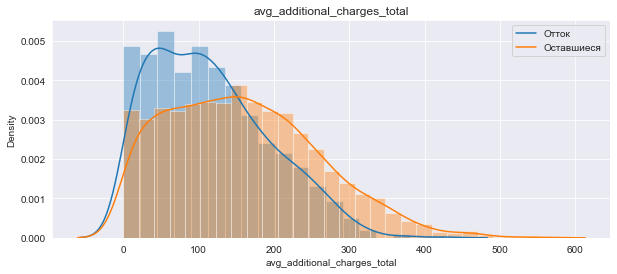

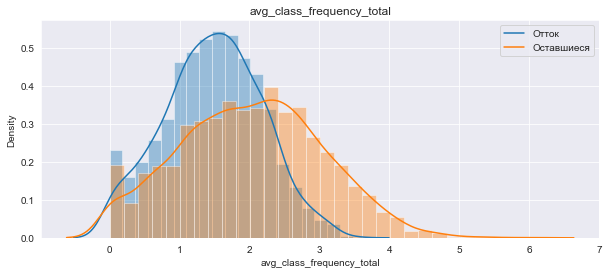

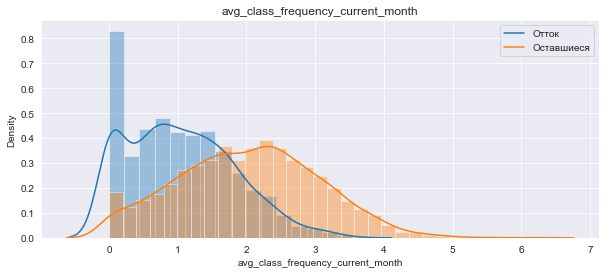

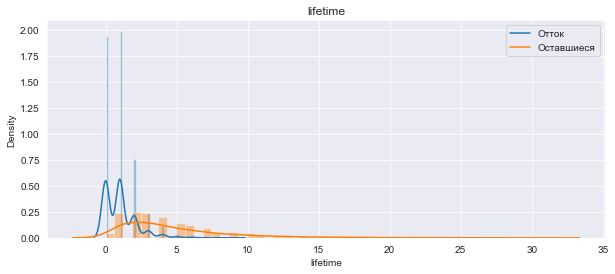

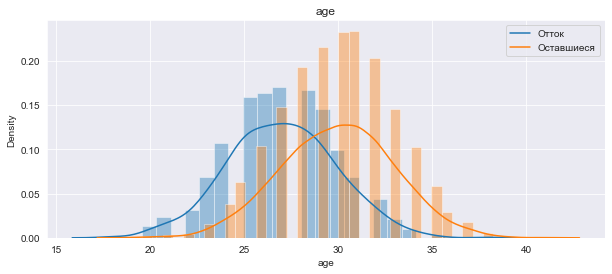

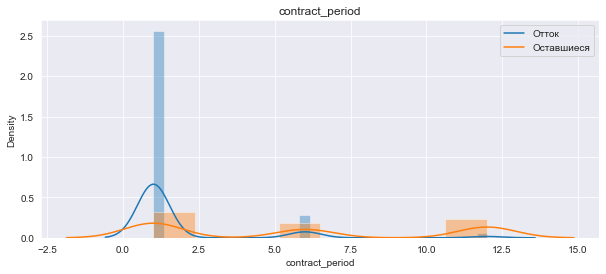

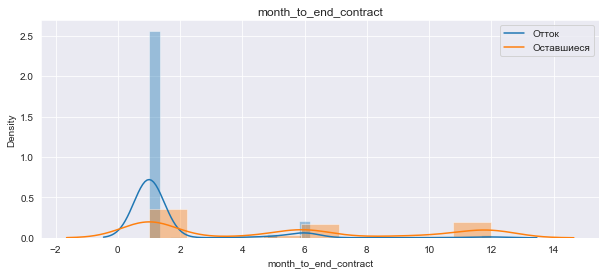

In [8]:
left = df[df['churn'] == 1]
stayed = df[df['churn'] == 0]
distplot_cols = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                 'avg_class_frequency_current_month', 'lifetime', 'age', 
                 'contract_period', 'month_to_end_contract']
for col in distplot_cols: 
    plt.figure(figsize=(10,4)) 
    plt.title(col)
    sns.distplot(left[col])
    sns.distplot(stayed[col])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

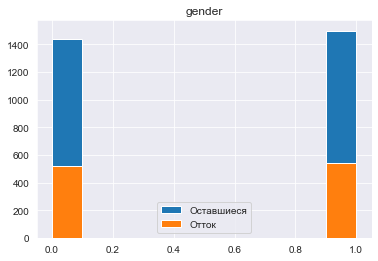

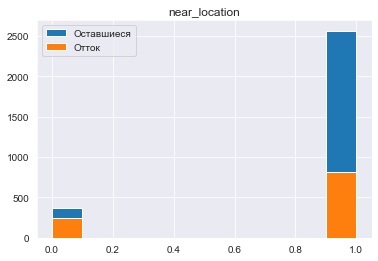

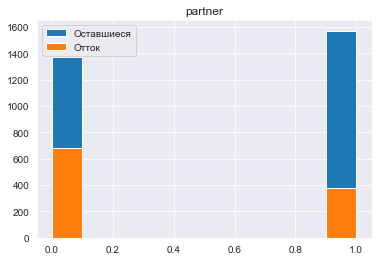

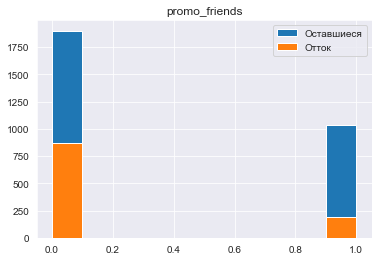

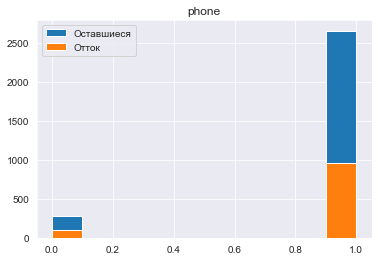

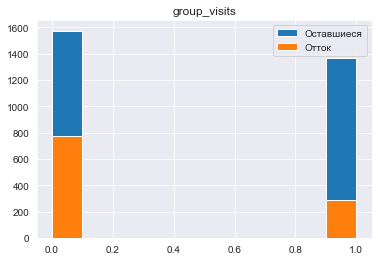

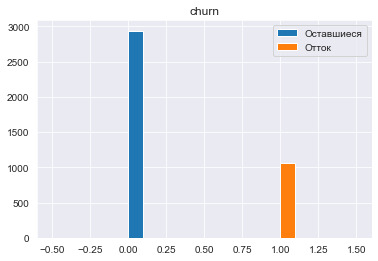

In [9]:
for col in df.columns:
    if col not in distplot_cols:
        df.groupby('churn')[col].hist()
        plt.title(col)
        plt.legend(['Оставшиеся', 'Отток'])
        plt.show()

Выводы из распределений:
- Распределение по полу не отличается
- Ближе живущие или работающие клиенты реже уходят, что вполне логично
- Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб чем остальные клиенты
- Клиенты, пришедшие по акции "приведи друга" в два раза реже уходят в отток
- Наличие мобильного номера клиента не отличается в группах
- Средняя длительность договора полне логично больше у оставшихся пользователей, у большей части клиентов в оттоке срок договора составляет 1  месяц (вполне возможно, что клиенты чаще всего заключают договор на 1 месяц и, при желании, продлевают его).
- Среди оставшихся клиентов выше доля тех, кто предпочитает групповые занятия
- У групп есть разница в среднем возрасте клиентов - оставшиеся клиенты в среднем старше, чем ушедшие
- Есть различие в выручке от других услуг фитнес-центра
- Срок до окончания текущего действующего абонемента логично больше у оставшихся клиентов

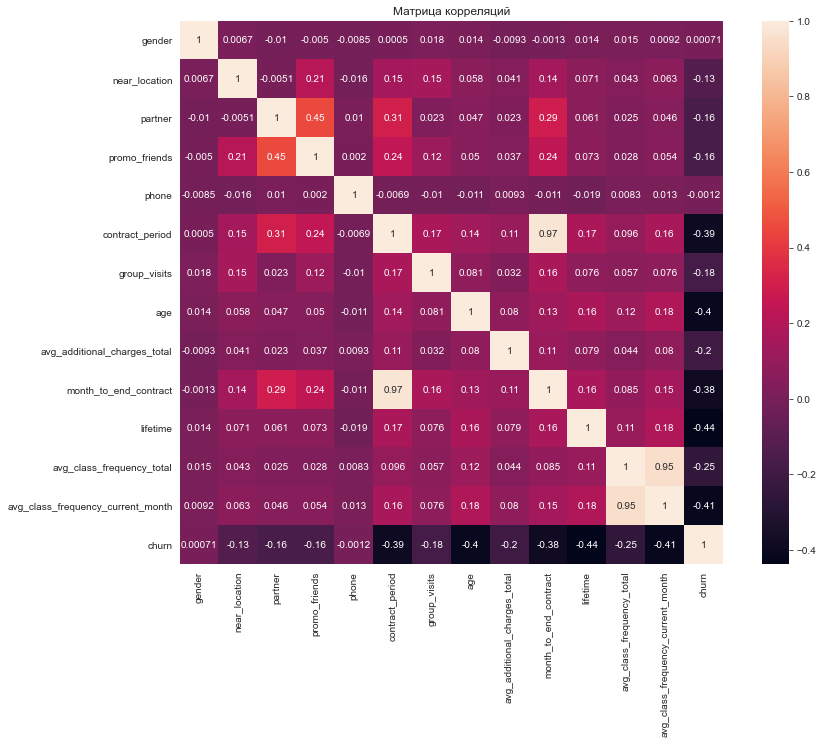

In [10]:
# Общая матрица корреляций
plt.figure(figsize=(14,10))
sns.heatmap(data=df.corr(), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

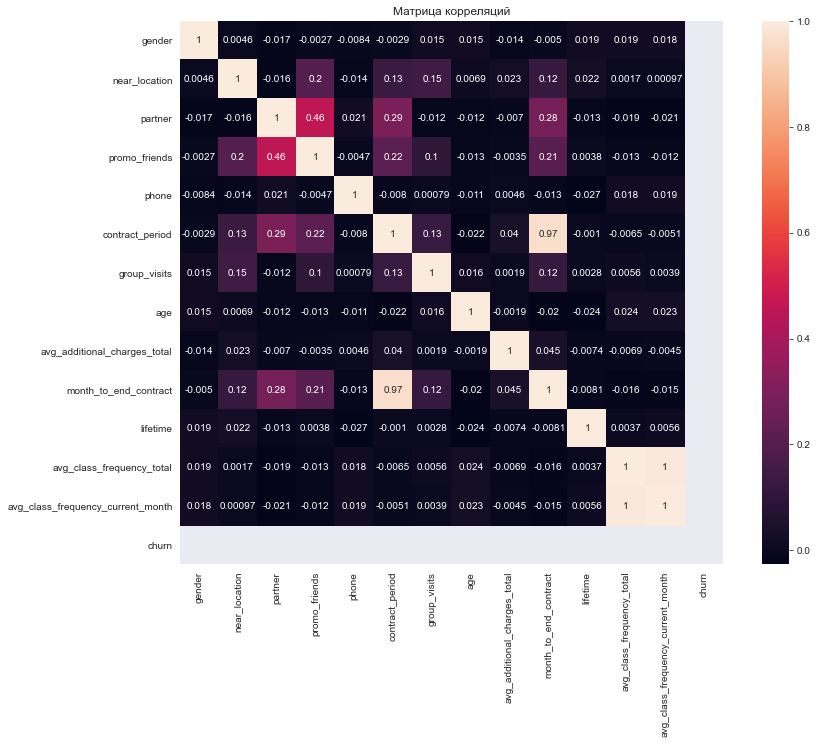

In [11]:
# Матрица корреляция для оставшихся клиентов
plt.figure(figsize=(14,10))
sns.heatmap(data=df[df['churn'] == 0].corr(), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

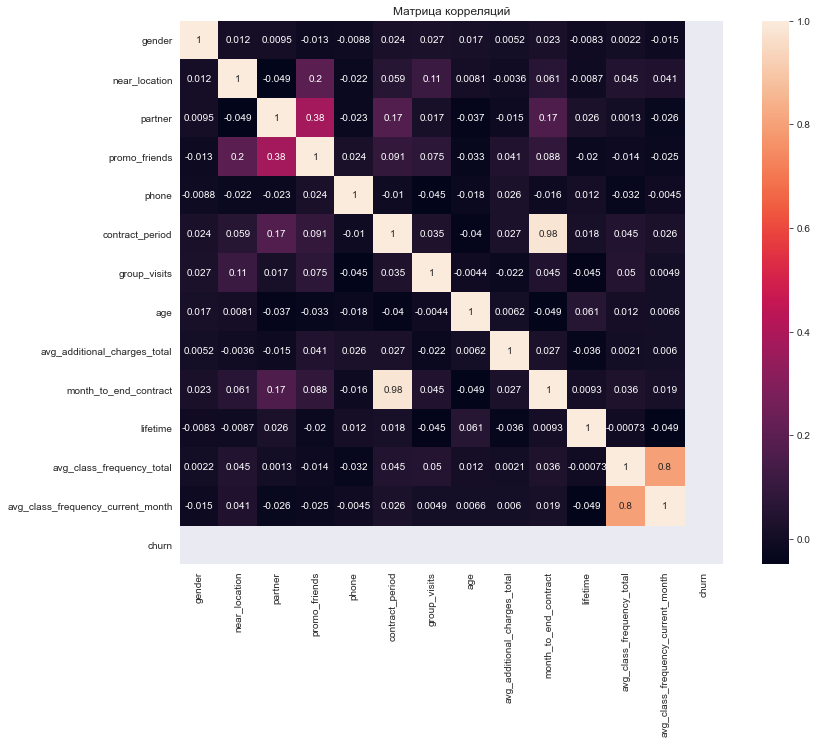

In [12]:
# Матрица корреляций для ушедших клиентв
plt.figure(figsize=(14,10))
sns.heatmap(data=df[df['churn'] == 1].corr(), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

In [13]:
df.corr().sort_values('churn', ascending=False, key=abs)['churn']

churn                                1.000000
lifetime                            -0.438220
avg_class_frequency_current_month   -0.412348
age                                 -0.404735
contract_period                     -0.389984
month_to_end_contract               -0.381393
avg_class_frequency_total           -0.249715
avg_additional_charges_total        -0.198697
group_visits                        -0.175325
promo_friends                       -0.162233
partner                             -0.157986
near_location                       -0.128098
phone                               -0.001177
gender                               0.000708
Name: churn, dtype: float64

Прямой зависимости между каждым из признаков и оттоком нет, но есть две пары мультиколлинеарных признака - month_to_end_contract и contract_period, avg_class_frequency_current_month и avg_class_frequency_total. 

Есть признаки практически с нулевой корреляцией с целевым признаком - gender и phone.

Самую большую корреляцию с оттоком имеют лайфтайм клиента, средняя частота посещений в неделю за предыдущий месяц и возраст клиента.

## Модели прогнозирования оттока клиентов

In [14]:
# Подготовим данные
X = df.drop(['churn'], axis = 1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [15]:
logreg_cv = LogisticRegression(random_state = 0)
rf_cv = RandomForestClassifier(random_state = 0)

Попробуем сделать небольшой тюнинг наших моделей с целью получения лучшего качества

### Логистическая регрессия

In [16]:
param_grid = {'C': np.linspace(-10, 10, 50), 
              'penalty': ['l1', 'l2', 'elasticnet']}

In [17]:
clf = GridSearchCV(logreg_cv, param_grid, cv = 5, verbose=0, n_jobs=-1)

In [18]:
# Работа этой ячейки может занимать некоторое время из-за перебора гиперпараметров
best_model = clf.fit(X_train_st, y_train)
print(best_model.best_estimator_)
print("Средняя точность измерений:", best_model.score(X_test_st, y_test))

LogisticRegression(C=8.775510204081634, random_state=0)
Средняя точность измерений: 0.9225


In [19]:
logreg_tuned = LogisticRegression(C=8.775510204081634, random_state=0)
logreg_tuned.fit(X_train_st, y_train)
y_pred_logreg_tuned = logreg_tuned.predict(X_test_st)

print('Метрики для модели логистической регрессии с подобранными гиперпараметрами')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, y_pred_logreg_tuned),
    precision_score(y_test, y_pred_logreg_tuned),
    recall_score(y_test, y_pred_logreg_tuned)))

Метрики для модели логистической регрессии с подобранными гиперпараметрами
accuracy_score: 0.9225
precision_score: 0.8541666666666666
recall_score:0.8282828282828283


In [20]:
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train_st, y_train)
y_pred_logreg = logreg.predict(X_test_st)

print('Метрики для модели логистической регрессии с дефолтными гиперпараметрами')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, y_pred_logreg),
    precision_score(y_test, y_pred_logreg),
    recall_score(y_test, y_pred_logreg)))

Метрики для модели логистической регрессии с дефолтными гиперпараметрами
accuracy_score: 0.9225
precision_score: 0.8541666666666666
recall_score:0.8282828282828283


In [21]:
print(pd.DataFrame(({'cols':X_train.columns, 'coefs':logreg_tuned.coef_[0]}))\
      .sort_values('coefs', ascending=False, key=abs))

                                 cols     coefs
12  avg_class_frequency_current_month -5.165971
10                           lifetime -4.185195
11          avg_class_frequency_total  3.942989
7                                 age -1.147030
5                     contract_period -0.767736
8        avg_additional_charges_total -0.581760
9               month_to_end_contract -0.529595
6                        group_visits -0.416468
3                       promo_friends -0.297876
2                             partner -0.086660
1                       near_location -0.079652
0                              gender -0.021885
4                               phone  0.016791


После того, как мы воспользовались стандартизованными данными, качество с подбором гиперпараметров не изменилось, но зато изменились коэфициенты у признаков: телефон ушёл вниз как наименее влияющий признак, наиболее сильными оказалось 2 мультиколлинеарных признака, лайфтайм и возраст клиента.

Попробуем обучить случайный лес

### Случайный лес

In [22]:
param_grid = { 
    'n_estimators': list(np.linspace(100, 1200, 10, dtype = int)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(np.linspace(1, 1200, 10, dtype = int)) + [None],
    'criterion' :['gini', 'entropy']
}

In [23]:
clf_rf = RandomizedSearchCV(rf_cv, param_grid, cv=5, verbose=0, n_jobs=-1)

In [24]:
# Работа этой ячейки может занимать некоторое время из-за перебора гиперпараметров
best_model_rf = clf_rf.fit(X_train_st, y_train)
print(best_model_rf.best_estimator_)
print("Средняя точность измерений:", best_model_rf.score(X_test_st, y_test))

RandomForestClassifier(max_depth=667, max_features='log2', n_estimators=466,
                       random_state=0)
Средняя точность измерений: 0.915


In [25]:
# Воспользуемся теми же подобранными параметрами, что и на нестандартизованных данных
rf_tuned = RandomForestClassifier(max_depth=667, n_estimators=1077, random_state=0)
rf_tuned.fit(X_train_st, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test_st)

print('Метрики для случайного леса с подобранными гиперпараметрами')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, y_pred_rf_tuned),
    precision_score(y_test, y_pred_rf_tuned),
    recall_score(y_test, y_pred_rf_tuned)))

Метрики для случайного леса с подобранными гиперпараметрами
accuracy_score: 0.91625
precision_score: 0.8393782383419689
recall_score:0.8181818181818182


In [26]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_st, y_train)
y_pred_rf = rf.predict(X_test_st)

print('Метрики для случайного леса с дефолтными гиперпараметрами')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_rf)))

Метрики для случайного леса с дефолтными гиперпараметрами
accuracy_score: 0.915
precision_score: 0.8385416666666666
recall_score:0.8131313131313131


In [27]:
print(pd.DataFrame(({'cols':X_train.columns, 'coefs':rf_tuned.feature_importances_}))\
      .sort_values('coefs', ascending=False))

                                 cols     coefs
10                           lifetime  0.284860
12  avg_class_frequency_current_month  0.177638
11          avg_class_frequency_total  0.129408
7                                 age  0.117509
8        avg_additional_charges_total  0.089268
9               month_to_end_contract  0.071151
5                     contract_period  0.063832
6                        group_visits  0.015763
3                       promo_friends  0.011842
0                              gender  0.011698
2                             partner  0.011577
1                       near_location  0.009236
4                               phone  0.006218


У нас получилось немного улучшить качество! Случайный лес, ожидаемо, показал себя лучше логистической регрессии, хотя разница между ними не столь велика, зато среди наиболее значимых признаков выделился лайфтайм, а наличие номера ушло на последнюю позицию.

Мы имеем не самые сложные данные, поэтому получили хорошее качество с простыми моделями даже без сложных настроек, в будущем можно потратить больше времени на улучшение качества.

### Кластеризация клиентов

In [28]:
df_cl = df.drop(['churn'], axis = 1)
df_cl.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


In [29]:
df_cl = pd.DataFrame(StandardScaler().fit_transform(df_cl), columns=df_cl.columns).astype('float64')
df_cl.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.979706,0.427881,1.026861,1.497161,-3.059852,0.289890,1.194032,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,-1.020715,0.427881,-0.973842,-0.667931,0.326813,1.608822,1.194032,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,-1.020715,0.427881,1.026861,-0.667931,0.326813,-0.809219,-0.837498,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,-1.020715,0.427881,1.026861,1.497161,0.326813,1.608822,1.194032,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,0.979706,0.427881,1.026861,1.497161,0.326813,-0.809219,-0.837498,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


In [30]:
# Матрица расстояний
linked = linkage(df_cl, method='ward')
linked

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

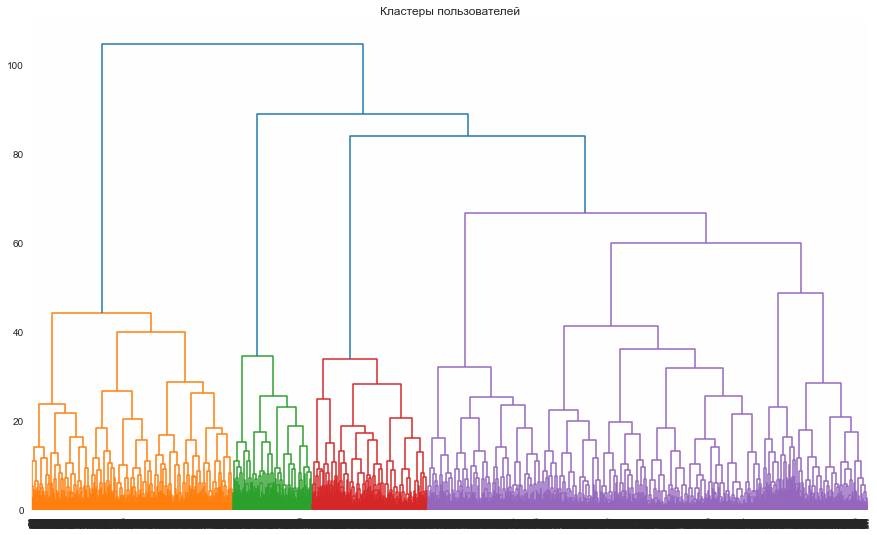

In [31]:
plt.figure(figsize=(15, 9))  
dendrogram(linked, orientation='top')
plt.title('Кластеры пользователей')
plt.show()

Судя по дендрограмме, можно выделить 4-5 кластеров. Кластеризуем пользователей с помощью алгоритма KMeans.

In [32]:
kmeans = KMeans(n_clusters=5, random_state=10)
labels = kmeans.fit_predict(df_cl)
df['cluster'] = labels

In [33]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,4


In [34]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.523316,0.561850,0.500577,0.485714,0.493569
near_location,0.862694,0.848555,0.936563,0.723810,0.948553
partner,0.471503,0.282081,0.740484,0.296032,0.813505
promo_friends,0.305699,0.073988,0.480969,0.011111,0.998392
phone,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4.777202,2.676301,11.833910,1.926190,3.020900
group_visits,0.427461,0.448555,0.547866,0.276984,0.437299
age,29.297927,30.047399,29.891580,28.135714,29.051447
avg_additional_charges_total,144.208179,161.300223,163.330735,129.407081,141.358831
month_to_end_contract,4.466321,2.476301,10.791234,1.832540,2.829582


In [35]:
df.groupby('cluster')['cluster'].count()

cluster
0     386
1     865
2     867
3    1260
4     622
Name: cluster, dtype: int64

Построим графики распределения признаков

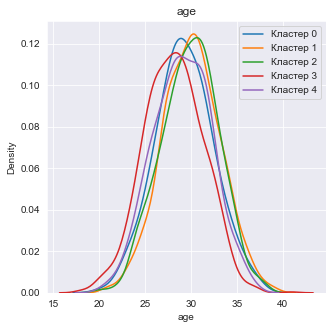

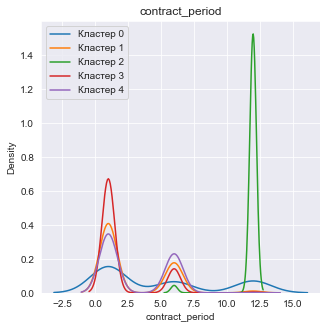

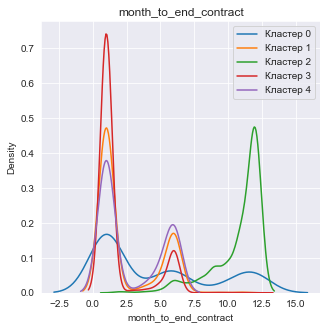

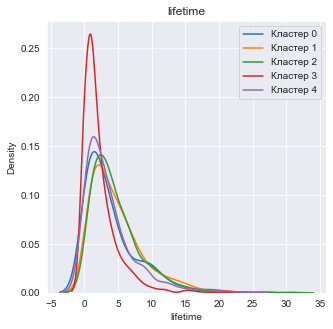

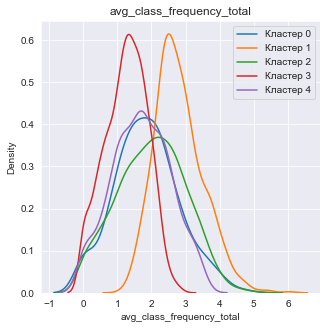

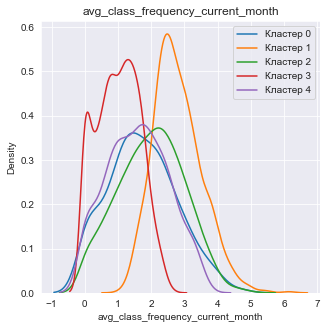

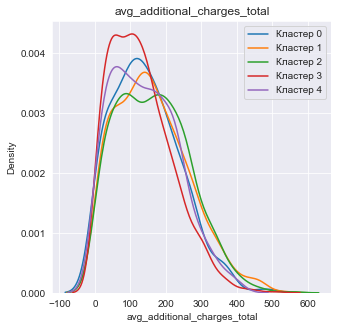

In [36]:
for column in ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 
               'avg_class_frequency_total', 'avg_class_frequency_current_month', 
               'avg_additional_charges_total']:
    plt.figure(figsize=(5, 5))
    plt.title(column)   
    sns.kdeplot(df.query('cluster==0')[column], label = 'Кластер 0')
    sns.kdeplot(df.query('cluster==1')[column], label = 'Кластер 1')
    sns.kdeplot(df.query('cluster==2')[column], label = 'Кластер 2')
    sns.kdeplot(df.query('cluster==3')[column], label = 'Кластер 3')
    sns.kdeplot(df.query('cluster==4')[column], label = 'Кластер 4')
    plt.legend()
    plt.show()

Самый большой отток - в самом многочисленном кластере 3 (56% оттока), за ним идут кластеры 0 и 4 (26% оттока). Самые малочисленные по оттоку - кластеры 1 и 2 (7% и 2% соответственно), и они выглядят наиболее стабильными по количеству попавших в них клиентов.

Кластер 3 в среднем:

- Немногим преобладает пол "0"
- Меньше всего клиентов, находящихся недалеко от фитнес-центра (72%)
- Редко являются сотрудниками компаний-партнёров (29%)
- Очень редко используют промо-код от другого человека (1%)
- Самый маленький период договора - в среднем 2 месяца
- Сильно реже других ходят на групповые тренировки (27%)
- Наименьшая суммарная выручка от других услуг фитнес-центра (129 единиц)
- Наименьший срок до окончания текущего действующего абонемента (менее 2 месяцев)
- Самый низкий лайфтайм
- Самая маленькая средняя частота посещений в неделю за все время с начала действия абонемента (1.25)
- Самая малеьная средняя частота посещений в неделю за предыдущий месяц (чуть больше 1, сильно отличается от частоты за всё время)

Кластер 2 в среднем:
- Равное распределение полов
- Большая часть клиентов - в близком расположении к фитнес-центру (93%)
- Большинство - сотрудники компаний-партнеров (74%)
- Почти половина пришла по промо-коду друга
- Самый длительный средний срок договора - почти год
- Более чем половина клиентов предпочитает групповые визиты (54%)
- Наибольшая суммарная выручка от других услуг фитнес-центра (163 единиц)
- Самый большой срок до окончания текущего действующего абонемента (более 10 месяцев)
- Самый большой лайфтайм
- Небольшую разницу средней частоты посещений в неделю между предыдущим месяцем и всем лайфтаймом клиента


## Вывод
Если рассматривать вкупе результаты кластерного анализа и полученные коэфициенты моделей машинного обучения, то можно сделать следующие выводы:

---
1. Важно развивать реферальную программу и мотивировать людей заниматься вместе - такие люди реже бросают спорт, что логично, ведь вместе заниматься веселее и есть ощущение ответственности перед другим человеком.
---
2. Люди, которые оформляют договор сразу на долгий период, вначале имеют довольно большую мотивацию и реже уходят, поэтому важно следить за динамикой посещаемости клиентом фитнес-центра относительно прыдыдущих временных отрезков и, может быть, рассылать SMS/push-уведомления с напоминаниями или какими-то предложениями, которые могли бы заставить человека вернуться.
---
3. Если человек оформляет договор не на столь длительный период, то он в среднем ходит в зал чаще, и при этом, как и у людей с длительными контрактами, в динамике не имеет тенденцию к сильному сокращению количества посещений в неделю, что лишний раз подтверждает необходимость следить за тем, меняется ли посещаемость у клиента, и применять меры в случае её ухудшения.
--- 
4. Люди с большим лайфтаймом уходят реже - скорее всего, такие люди уже привыкают к конкретному фитнес-центру и уже представляют нашу постоянную клиентскую базу, и чтобы такие люди ушли, скорее всего, нужны серьезные обстоятельства, напрямую не зависящие от нас - поэтому важно привлекать клиента на долгосрочный период, предлагать более длительные абонементы и, как уже было озвучено, следить за тем, чтобы у клиента не упала мотивация посещать зал.